In [1]:
!nvidia-smi

Fri Jan 17 01:36:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.26       Driver Version: 430.26       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1D:00.0 Off |                  N/A |
| 27%   32C    P8    14W / 250W |     10MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1E:00.0 Off |                  N/A |
| 27%   33C    P0    76W / 250W |     10MiB / 11019MiB |     18%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import matplotlib.pyplot as plt
import cv2

import sys
sys.path.append('/mnt/disk1/project/SMhospital/capsule/ce_packages')

from ce_utils import load_data, one_hot, test_batch_idxs, batch_flatten
from ce_utils import model_prob
from ce_utils import classification_metric
from ce_model import binary_model, ensemble_model

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Load Data

In [3]:
from itertools import product
import glob

def target_preprocessings(phase_a_switch = [1, 1, 1, 1], phase_b_switch = True):
    """
    phase_a_switch = [1, 1, 1, 1], [1, 0, 0 ,1], [1, 1, 0, 1].... 
    that means [cropping, flip, rotate, blur_sharp]
    """
    phase0 = ['_c']
    phase1 = {1: ['-', 'f'], 0: ['-']}
    phase2 = {1: ['-', 'r1', 'r2', 'r3'], 0: ['-']}
    phase3 = {1: ['-', 'ab', 'mb', 'eh'], 0: ['-']}
    phase4 = ['s_-30_v_30', 's_-30_v_-30', 's_30_v_-30', 's_30_v_30']
    
    if phase_a_switch[0] == 1:
        phase_a_items = [phase0, phase1[phase_a_switch[1]], phase2[phase_a_switch[2]], phase3[phase_a_switch[3]]]
    elif phase_a_switch[0] == 0:
        phase_a_items = [phase1[phase_a_switch[1]], phase2[phase_a_switch[2]], phase3[phase_a_switch[3]]]
    
    phase_a = []
    for i in list(product(*phase_a_items)):
        phase_a.append('_'.join(i))

    if not phase_b_switch != True:
        phase_b = []
        for i in list(product(*[phase_a, phase4])):
            phase_b.append('_'.join(i))
        return list(np.hstack([phase_a, phase_b]))
    else:
        return phase_a 

class ce_load_dataset:
    def __init__(self, phase, data, pre_a, pre_b, img_ch, ext_name):
        self.phase = phase        # 'train' or 'test'
        self.data = data          # 'sm', 'sm_core', 'sm_v2', 'sm_x160', ...
        self.pre_a = pre_a        # [1, 1, 1, 1], [1, 0, 0 ,1], [1, 1, 0, 1].... 
        self.pre_b = pre_b        # True or False
        self.img_ch = img_ch      # 'bgr', 'rgb', and 'hsv'
        self.ext_name = ext_name  # True or False

    def load_path(self, phase, cls, les, data = 'sm', data_dir = '/mnt/disk2/data/private_data/SMhospital/capsule/1 preprocessed', 
                  pre_a = [0, 0, 0, 0], pre_b = False):
        """
        phase = 'train', 'test'
        cls: [les]  
          'n': ['neg']
          'h': ['redspot', 'angio', 'active'], 
          'd': ['ero', 'ulc', 'str'],
          'p': ['amp', 'lym', 'tum']}
        pre_a[0] must be 0
        """
        lesions = dict(neg = 'negative', 
                       redspot = 'red_spot', angio = 'angioectasia', active = 'active_bleeding', 
                       ero = 'erosion', ulcer = 'ulcer', str = 'stricture', 
                       amp = 'ampulla_of_vater', lym = 'lymphoid_follicles', tum = 'small_bowel_tumor')
        classes = dict(n = 'negative', h = 'hemorrhagic', d = 'depressed', p = 'protruded')

        path = os.path.join(data_dir, data, phase, classes[cls], lesions[les])
        pathlist = glob.glob(path + '/*.jpg')
        if pre_a != [1, 1, 1, 1]:
            path_in_phase = []
            for p in pathlist:
                if (p.split('c_')[-1])[:-4] in target_preprocessings(pre_a, pre_b):
                    path_in_phase.append(p)   
            return np.asarray(path_in_phase)
        else:
            return np.asarray(pathlist)

    def load_image_from_path(self, pathlist,image_ch = 'bgr', extract_name = False):
        data = []
        for i in pathlist:
            temp = cv2.imread(i)
            if image_ch == 'bgr':
                pass
            elif image_ch == 'rgb':
                temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
            elif image_ch == 'hsv':
                temp = cv2.cvtColor(temp, cv2.COLOR_BGR2HSV)
            data.append(temp)
        if extract_name != False:
            name = []
            for i in pathlist:
                name.append(os.path.basename(i))
            return np.asarray(data), np.asarray(name)
        else:
            return np.asarray(data) 

    def load_data(self, cls, les):
        pathlist = self.load_path(self.phase,  cls, les,  data = self.data, pre_a = self.pre_a, pre_b = self.pre_b)
        return  self.load_image_from_path(pathlist, image_ch = self.img_ch, extract_name = self.ext_name)

In [4]:
ce = ce_load_dataset(phase = 'test', data = 'sm_x160', pre_a = [0, 0, 0, 1], pre_b = False, img_ch = 'bgr', ext_name = True)

In [5]:
neg_testset = ce.load_data('n', 'neg')
redspot_testset = ce.load_data('h', 'redspot')
angio_testset = ce.load_data('h', 'angio')
active_testset = ce.load_data('h', 'active')
ero_testset = ce.load_data('d', 'ero')
ulcer_testset = ce.load_data('d', 'ulcer')
str_testset = ce.load_data('d', 'str')

neg_label = one_hot(neg_testset[0], 0)
redspot_label = one_hot(redspot_testset[0], 1)
angio_label = one_hot(angio_testset[0], 1)
active_label = one_hot(active_testset[0], 1)
ero_label = one_hot(ero_testset[0], 1)
ulcer_label = one_hot(ulcer_testset[0], 1)
str_label = one_hot(str_testset[0], 1)

print("negative:",neg_testset[0].shape, neg_label.shape)
print("red spot:",redspot_testset[0].shape, redspot_label.shape)
print("angioectasia:",angio_testset[0].shape, angio_label.shape)
print("active_bleeding:",active_testset[0].shape, active_label.shape)
print("erosion:",ero_testset[0].shape, ero_label.shape)
print("ulcer:",ulcer_testset[0].shape, ulcer_label.shape)
print("stricture:",str_testset[0].shape, str_label.shape)

negative: (5796, 512, 512, 3) (5796, 2)
red spot: (456, 512, 512, 3) (456, 2)
angioectasia: (12, 512, 512, 3) (12, 2)
active_bleeding: (488, 512, 512, 3) (488, 2)
erosion: (484, 512, 512, 3) (484, 2)
ulcer: (564, 512, 512, 3) (564, 2)
stricture: (124, 512, 512, 3) (124, 2)


In [6]:
neg_testset[1]

array(['CW___02-49-14___1020312__c_-_-_-.jpg',
       'CW___02-49-14___1020312__c_-_-_ab.jpg',
       'CW___02-49-14___1020312__c_-_-_mb.jpg', ...,
       '희정___05-21-26___2053556__c_-_-_ab.jpg',
       '희정___05-21-26___2053556__c_-_-_mb.jpg',
       '희정___05-21-26___2053556__c_-_-_eh.jpg'], dtype='<U37')

# Model Inference

In [7]:
nh_list = sorted([i[:-5] for i in os.listdir('./model') if 'meta' in i and 'X160_NX8H' in i])
nd_list = sorted([i[:-5] for i in os.listdir('./model') if 'meta' in i and 'X160_NX8D' in i])
b_list = sorted([i[:-5] for i in os.listdir('./model') if 'meta' in i and 'X160_NX8A' in i])

In [8]:
nh_list

['X160_NX8H_2001161706_1780_val_acc_1.00_val_loss_0.000070',
 'X160_NX8H_2001161804_4660_val_acc_1.00_val_loss_0.000001',
 'X160_NX8H_2001161845_6680_val_acc_1.00_val_loss_0.000000',
 'X160_NX8H_2001162013_11010_val_acc_1.00_val_loss_0.000000',
 'X160_NX8H_2001162030_11850_val_acc_1.00_val_loss_0.000000']

In [9]:
nd_list

['X160_NX8D_2001170008_24560_val_acc_1.00_val_loss_0.000036',
 'X160_NX8D_2001170023_25390_val_acc_1.00_val_loss_0.000033',
 'X160_NX8D_2001170057_27260_val_acc_1.00_val_loss_0.000031',
 'X160_NX8D_2001170103_27580_val_acc_1.00_val_loss_0.000020',
 'X160_NX8D_2001170116_28280_val_acc_1.00_val_loss_0.000005']

In [10]:
b_list

['X160_NX8A_2001162314_21730_val_acc_1.00_val_loss_0.000762',
 'X160_NX8A_2001162351_23750_val_acc_1.00_val_loss_0.000651',
 'X160_NX8A_2001162353_23870_val_acc_1.00_val_loss_0.000588',
 'X160_NX8A_2001170032_26000_val_acc_1.00_val_loss_0.000514',
 'X160_NX8A_2001170050_27000_val_acc_1.00_val_loss_0.000312']

In [11]:
nh_path = './model/' + nh_list[-1]
nd_path = './model/' + nd_list[-1]
b_path = './model/' + b_list[-1]

NH_model = binary_model(nh_path)
ND_model = binary_model(nd_path)
E_model = ensemble_model(nh_path, nd_path)
B_model = binary_model(b_path)

W0117 01:36:49.432636 140108116788992 deprecation_wrapper.py:119] From /mnt/disk1/project/SMhospital/capsule/ce_packages/ce_model.py:108: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0117 01:36:49.721900 140108116788992 deprecation_wrapper.py:119] From /mnt/disk1/project/SMhospital/capsule/ce_packages/ce_model.py:109: The name tf.train.import_meta_graph is deprecated. Please use tf.compat.v1.train.import_meta_graph instead.

W0117 01:36:50.088330 140108116788992 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [12]:
neg_e_output, neg_nh_output, neg_nd_output = model_prob(E_model, neg_testset[0], model_type = 'ensemble')
redspot_e_output, redspot_nh_output, redspot_nd_output = model_prob(E_model, redspot_testset[0], model_type = 'ensemble')
angio_e_output, angio_nh_output, angio_nd_output = model_prob(E_model, angio_testset[0], model_type = 'ensemble')
active_e_output, active_nh_output, active_nd_output = model_prob(E_model, active_testset[0], model_type = 'ensemble')
ero_e_output, ero_nh_output, ero_nd_output = model_prob(E_model, ero_testset[0], model_type = 'ensemble')
ulcer_e_output, ulcer_nh_output, ulcer_nd_output = model_prob(E_model, ulcer_testset[0], model_type = 'ensemble')
str_e_output, str_nh_output, str_nd_output  = model_prob(E_model, str_testset[0], model_type = 'ensemble')

#: 5796 / Inference Time: 00:01:03
#: 456 / Inference Time: 00:00:05
#: 12 / Inference Time: 00:00:00
#: 488 / Inference Time: 00:00:06
#: 484 / Inference Time: 00:00:06
#: 564 / Inference Time: 00:00:06
#: 124 / Inference Time: 00:00:02


In [13]:
neg_b_output = model_prob(B_model, neg_testset[0])
redspot_b_output = model_prob(B_model, redspot_testset[0])
angio_b_output = model_prob(B_model, angio_testset[0])
active_b_output = model_prob(B_model, active_testset[0])
ero_b_output = model_prob(B_model, ero_testset[0])
ulcer_b_output = model_prob(B_model, ulcer_testset[0])
str_b_output  = model_prob(B_model, str_testset[0])

#: 5796 / Inference Time: 00:00:30
#: 456 / Inference Time: 00:00:02
#: 12 / Inference Time: 00:00:00
#: 488 / Inference Time: 00:00:02
#: 484 / Inference Time: 00:00:02
#: 564 / Inference Time: 00:00:03
#: 124 / Inference Time: 00:00:00


In [14]:
h_label = np.vstack([redspot_label, angio_label, active_label])
d_label = np.vstack([ero_label, ulcer_label, str_label])
labels = np.vstack([neg_label, h_label, d_label])

h_b_output = np.vstack([redspot_b_output, angio_b_output, active_b_output])
d_b_output = np.vstack([ero_b_output, ulcer_b_output, str_b_output])
b_outputs = np.vstack([neg_e_output, h_b_output, d_b_output])

h_e_output = np.vstack([redspot_e_output, angio_e_output, active_e_output])
d_e_output = np.vstack([ero_e_output, ulcer_e_output, str_e_output])
e_outputs = np.vstack([neg_e_output, h_e_output, d_e_output])

# Evaluation

In [15]:
cls = classification_metric()

## Accuracy per lesion

In [16]:
neg_nh_acc = cls.accuracy(neg_label, neg_nh_output)
redspot_nh_acc = cls.accuracy(redspot_label, redspot_nh_output)
angio_nh_acc = cls.accuracy(angio_label, angio_nh_output)
active_nh_acc = cls.accuracy(active_label, active_nh_output)

Accuracy: 97.05 %
Accuracy: 37.94 %
Accuracy: 100.00 %
Accuracy: 45.90 %


In [17]:
neg_nd_acc = cls.accuracy(neg_label, neg_nd_output)
ero_nd_acc = cls.accuracy(ero_label, ero_nd_output)
ulcer_nd_acc = cls.accuracy(ulcer_label, ulcer_nd_output)
str_nd_acc = cls.accuracy(str_label, str_nd_output)

Accuracy: 98.78 %
Accuracy: 72.93 %
Accuracy: 48.05 %
Accuracy: 95.97 %


In [18]:
neg_b_acc = cls.accuracy(neg_label, neg_b_output)
redspot_b_acc = cls.accuracy(redspot_label, redspot_b_output)
angio_b_acc = cls.accuracy(angio_label, angio_b_output)
active_b_acc = cls.accuracy(active_label, active_b_output)
ero_b_acc = cls.accuracy(ero_label, ero_b_output)
ulcer_b_acc = cls.accuracy(ulcer_label, ulcer_b_output)
str_b_acc = cls.accuracy(str_label, str_b_output)

Accuracy: 97.03 %
Accuracy: 70.61 %
Accuracy: 100.00 %
Accuracy: 96.31 %
Accuracy: 83.47 %
Accuracy: 56.38 %
Accuracy: 94.35 %


In [19]:
h_b_acc = cls.accuracy(h_label, h_b_output)
d_b_acc = cls.accuracy(d_label, d_b_output)

Accuracy: 84.10 %
Accuracy: 71.59 %


In [20]:
neg_e_acc = cls.accuracy(neg_label, neg_e_output)
redspot_e_acc = cls.accuracy(redspot_label, redspot_e_output)
angio_e_acc = cls.accuracy(angio_label, angio_e_output)
active_e_acc = cls.accuracy(active_label, active_e_output)
ero_e_acc = cls.accuracy(ero_label, ero_e_output)
ulcer_e_acc = cls.accuracy(ulcer_label, ulcer_e_output)
str_e_acc = cls.accuracy(str_label, str_e_output)

Accuracy: 96.26 %
Accuracy: 66.45 %
Accuracy: 100.00 %
Accuracy: 90.57 %
Accuracy: 73.55 %
Accuracy: 57.45 %
Accuracy: 95.97 %


In [21]:
h_e_acc = cls.accuracy(h_label, h_e_output)
d_e_acc = cls.accuracy(d_label, d_e_output)

Accuracy: 79.18 %
Accuracy: 68.17 %


## Confusion Matrix

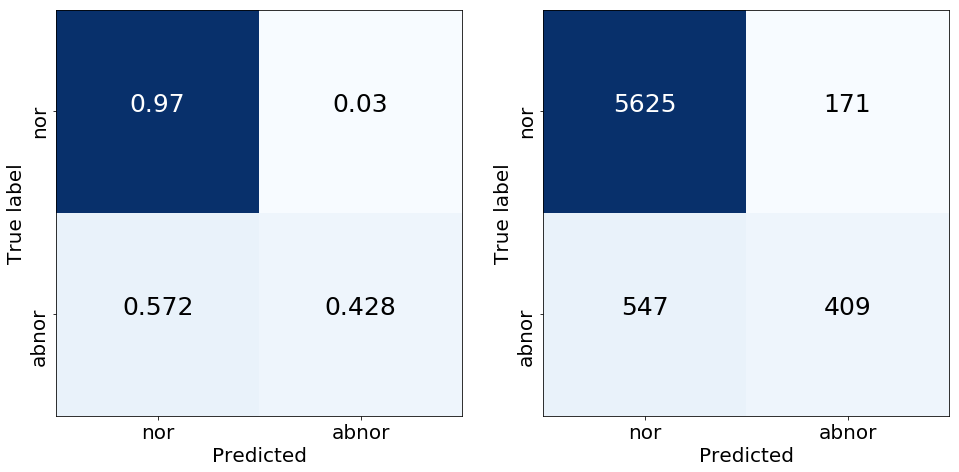

In [22]:
nh_outputs = np.vstack([neg_nh_output, redspot_nh_output, angio_nh_output, active_nh_output])
nh_labels = np.vstack([neg_label, redspot_label, angio_label, active_label])

nh_CM = cls.con_mat(nh_labels, nh_outputs)

plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(nh_CM, value_size = 25, label_size = 20)
plt.subplot(122)
cls.plot_cm(nh_CM, value_size = 25, label_size = 20, mode = 'num')
plt.show()

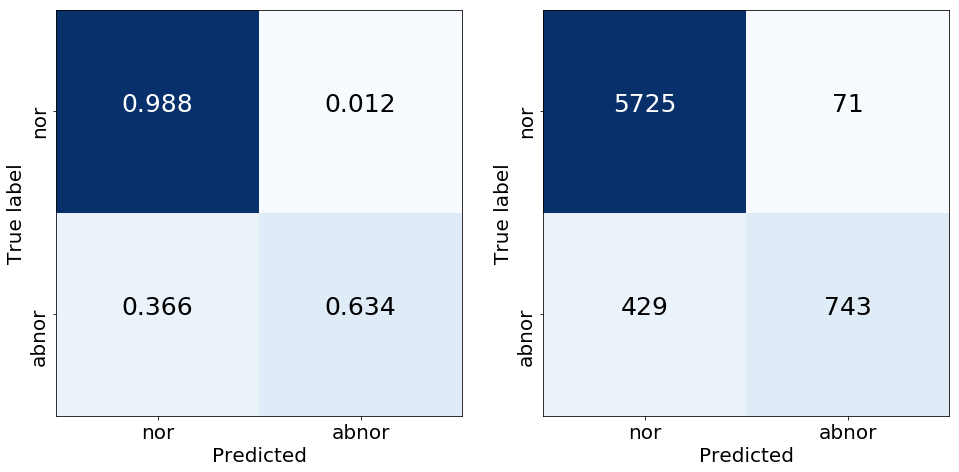

In [23]:
nd_outputs = np.vstack([neg_nd_output, ero_nd_output, ulcer_nd_output, str_nd_output])
nd_labels = np.vstack([neg_label, ero_label, ulcer_label, str_label])

nd_CM = cls.con_mat(nd_labels, nd_outputs)

plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(nd_CM, value_size = 25, label_size = 20)
plt.subplot(122)
cls.plot_cm(nd_CM, value_size = 25, label_size = 20, mode = 'num')
plt.show()

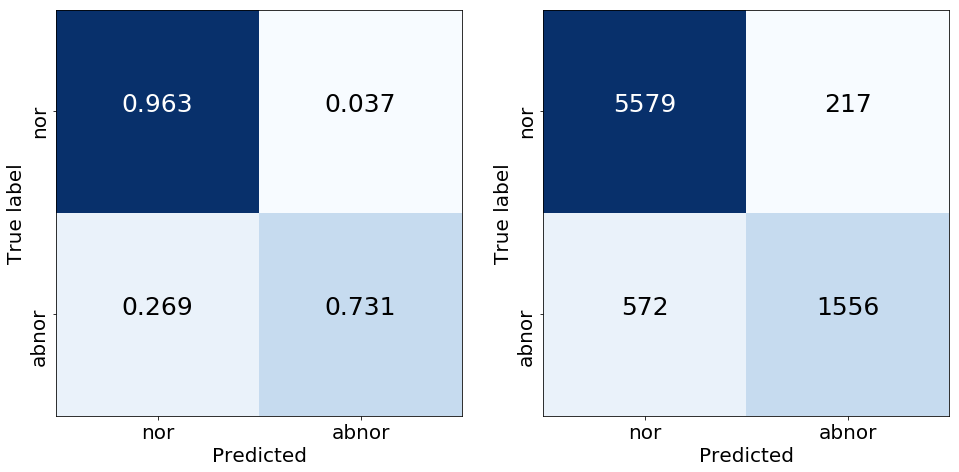

In [24]:
e_CM = cls.con_mat(labels, e_outputs)

plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(e_CM, value_size = 25, label_size = 20)
plt.subplot(122)
cls.plot_cm(e_CM, value_size = 25, label_size = 20, mode = 'num')
plt.show()

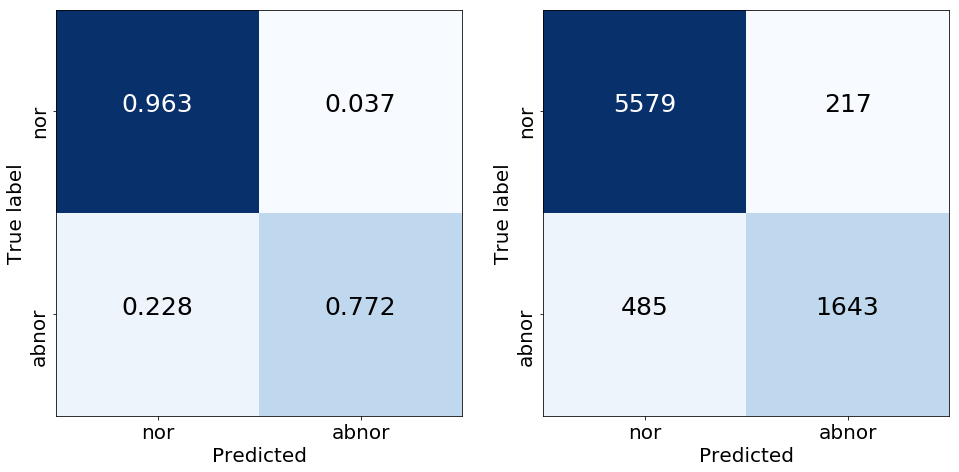

In [25]:
b_CM = cls.con_mat(labels, b_outputs)

plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(b_CM, value_size = 25, label_size = 20)
plt.grid(False)
plt.subplot(122)
cls.plot_cm(b_CM, value_size = 25, label_size = 20, mode = 'num')
plt.grid(False)
plt.show()

## ROC curve

In [26]:
from scipy.stats import sem, t
from scipy import mean

def conf_interval(data, conf_level = 0.95, mode = 'value', metric = 'Accr'):
    n = len(data)
    m = mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + conf_level) / 2, n - 1)

    start = m - h
    end = m + h
    
    if mode == 'value':
        return m, start, end
    elif mode == 'print':
        return print("{} --- {:.2f} ({:.2f} ~ {:.2f})".format(metric, m, start, end))

In [27]:
from sklearn.model_selection import KFold

def k_fold_idx(n_fold, dataset):
    kf = KFold(n_splits = n_fold, shuffle = True)
    train_idxs = []
    test_idxs = []
    for train_idx, test_idx in kf.split(dataset):
        train_idxs.append(train_idx)
        test_idxs.append(test_idx)
    return train_idxs, test_idxs

In [28]:
n_g = 10

_, neg_idxs = k_fold_idx(n_fold = n_g, dataset = neg_label)
_, h_idxs = k_fold_idx(n_fold = n_g, dataset = h_label)
_, d_idxs = k_fold_idx(n_fold = n_g, dataset = d_label)

In [29]:
def tri_shuffle(x, y, z):
    rand_idx = np.random.choice(len(x), len(x), replace = False)
    return x[rand_idx], y[rand_idx], z[rand_idx]

In [30]:
h_label, h_b_output, h_e_output = tri_shuffle(h_label, h_b_output, h_e_output)
d_label, d_b_output, d_e_output = tri_shuffle(d_label, d_b_output, d_e_output)

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


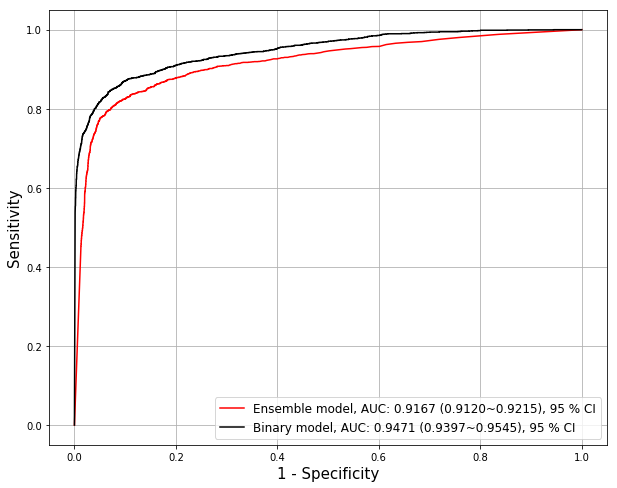

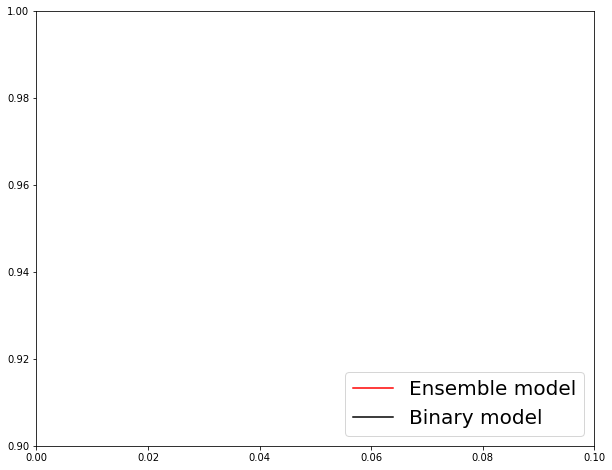

In [31]:
from sklearn.metrics import roc_curve, auc

e_aucs, b_aucs = [], []

for n_idx, h_idx, d_idx in zip(neg_idxs, h_idxs, d_idxs):

    labels = np.vstack([neg_label[n_idx], h_label[h_idx], d_label[d_idx]])
    b_outputs = np.vstack([neg_b_output[n_idx], h_b_output[h_idx], d_b_output[d_idx]]) 
    e_outputs = np.vstack([neg_e_output[n_idx], h_e_output[h_idx], d_e_output[d_idx]]) 
    
    e_fpr, e_tpr, thresholds = roc_curve(labels[:, 1], e_outputs[:,1])
    b_fpr, b_tpr, thresholds = roc_curve(labels[:, 1], b_outputs[:,1])
    e_aucs.append(auc(e_fpr, e_tpr))
    b_aucs.append(auc(b_fpr, b_tpr))

e_auc_m, e_auc_l, e_auc_u = conf_interval(e_aucs, mode = 'value')
b_auc_m, b_auc_l, b_auc_u = conf_interval(b_aucs, mode = 'value')

labels = np.vstack([neg_label, h_label, d_label])
b_outputs = np.vstack([neg_b_output, h_b_output, d_b_output])
e_outputs = np.vstack([neg_e_output, h_e_output, d_e_output])

labels, b_outputs, e_outputs = tri_shuffle(labels, b_outputs, e_outputs)

e_fpr, e_tpr, thresholds = roc_curve(labels[:, 1], e_outputs[:,1])
b_fpr, b_tpr, thresholds = roc_curve(labels[:, 1], b_outputs[:,1])

fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-', label="Ensemble model, AUC: {:.4f} ({:.4f}~{:.4f}), 95 % CI".format(e_auc_m, e_auc_l, e_auc_u))
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model, AUC: {:.4f} ({:.4f}~{:.4f}), 95 % CI".format(b_auc_m, b_auc_l, b_auc_u))
plt.xlabel('1 - Specificity', fontsize = 15)
plt.ylabel('Sensitivity', fontsize = 15)
plt.legend(fontsize = 12)
plt.grid('on')
fig.show()

fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-', label="Ensemble model")
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model")
plt.xlim([0.0, 0.1])
plt.ylim([0.9, 1.0])
plt.legend(fontsize = 20, loc = 4)
fig.show()

## Statistics

![image](http://mblogthumb3.phinf.naver.net/20121114_106/istech7_1352875002440GYyqh_PNG/%B5%CE%C1%FD%B4%DC%C2%F7%C0%CC_%B0%CB%C1%A4%B9%E6%B9%FD%C8%E5%B8%A7%B5%B5.png?type=w2)

![image](https://t1.daumcdn.net/cfile/tistory/2743524658F2520C2A)

https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F1378B94E4F9C187F23

In [32]:
e_CM, b_CM = [], []

for n_idx, h_idx, d_idx in zip(neg_idxs, h_idxs, d_idxs):
    labels = np.vstack([neg_label[n_idx], h_label[h_idx], d_label[d_idx]])
    b_outputs = np.vstack([neg_b_output[n_idx], h_b_output[h_idx], d_b_output[d_idx]]) 
    e_outputs = np.vstack([neg_e_output[n_idx], h_e_output[h_idx], d_e_output[d_idx]]) 
    e_CM.append(cls.con_mat(labels, e_outputs)), b_CM.append(cls.con_mat(labels, b_outputs))

In [33]:
b_metrices = []
e_metrices = []

for e_cm, b_cm in zip(e_CM, b_CM):
    b_metrices.append(cls.cm2metric(b_cm))
    e_metrices.append(cls.cm2metric(e_cm))
    
b_metrices = np.asarray(b_metrices)
e_metrices = np.asarray(e_metrices)

In [34]:
b_metrices

array([[0.91057935, 0.75233645, 0.96896552, 0.91382114, 0.89944134],
       [0.92191436, 0.82242991, 0.95862069, 0.93602694, 0.88      ],
       [0.92055485, 0.78873239, 0.96896552, 0.92586491, 0.90322581],
       [0.91803279, 0.79342723, 0.9637931 , 0.92703151, 0.88947368],
       [0.89785624, 0.70422535, 0.96896552, 0.8992    , 0.89285714],
       [0.91298865, 0.76056338, 0.96896552, 0.91680261, 0.9       ],
       [0.91529709, 0.77830189, 0.96545769, 0.92244224, 0.89189189],
       [0.92288243, 0.75943396, 0.98272884, 0.91774194, 0.94152047],
       [0.91529709, 0.75471698, 0.97409326, 0.91558442, 0.91428571],
       [0.93552465, 0.80660377, 0.98272884, 0.93278689, 0.94475138]])

In [35]:
e_metrices

array([[0.89546599, 0.70093458, 0.96724138, 0.8976    , 0.88757396],
       [0.90554156, 0.77570093, 0.95344828, 0.92013311, 0.86010363],
       [0.90668348, 0.76056338, 0.96034483, 0.91611842, 0.87567568],
       [0.90037831, 0.72769953, 0.9637931 , 0.90599676, 0.88068182],
       [0.889029  , 0.67605634, 0.96724138, 0.89047619, 0.88343558],
       [0.89659521, 0.72300469, 0.96034483, 0.90422078, 0.8700565 ],
       [0.90391909, 0.73113208, 0.9671848 , 0.9076175 , 0.8908046 ],
       [0.8874842 , 0.68867925, 0.96027634, 0.89389068, 0.86390533],
       [0.91150442, 0.75471698, 0.96891192, 0.91517129, 0.8988764 ],
       [0.90771176, 0.77358491, 0.95682211, 0.92026578, 0.86772487]])

In [36]:
print("95 % CI\n")

print('Binary model')
conf_interval(100*b_metrices[:, 0], mode = 'print', metric = 'Accr')
conf_interval(100*b_metrices[:, 1], mode = 'print', metric = 'Sen')
conf_interval(100*b_metrices[:, 2], mode = 'print', metric = 'Spec')
conf_interval(100*b_metrices[:, 3], mode = 'print', metric = 'NPV')
conf_interval(100*b_metrices[:, 4], mode = 'print', metric = 'PPV')
print('')
print('Ensemble model')
conf_interval(100*e_metrices[:, 0], mode = 'print', metric = 'Accr')
conf_interval(100*e_metrices[:, 1], mode = 'print', metric = 'Sen')
conf_interval(100*e_metrices[:, 2], mode = 'print', metric = 'Spec')
conf_interval(100*e_metrices[:, 3], mode = 'print', metric = 'NPV')
conf_interval(100*e_metrices[:, 4], mode = 'print', metric = 'PPV')

95 % CI

Binary model
Accr --- 91.71 (91.02 ~ 92.40)
Sen --- 77.21 (74.81 ~ 79.60)
Spec --- 97.03 (96.48 ~ 97.58)
NPV --- 92.07 (91.32 ~ 92.83)
PPV --- 90.57 (89.02 ~ 92.13)

Ensemble model
Accr --- 90.04 (89.46 ~ 90.62)
Sen --- 73.12 (70.62 ~ 75.63)
Spec --- 96.26 (95.89 ~ 96.62)
NPV --- 90.71 (89.95 ~ 91.48)
PPV --- 87.79 (86.89 ~ 88.69)


### Equal-Variance Test

In [37]:
from scipy.stats import bartlett

accr_stats = bartlett(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = bartlett(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = bartlett(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = bartlett(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = bartlett(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("bartlett test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("bartlett test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("bartlett test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("bartlett test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("bartlett test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

bartlett test for accuracy: 0.274, pvalue=0.600781855622
bartlett test for sensitivity: 0.017, pvalue=0.895519491929
bartlett test for specificity: 1.347, pvalue=0.245867586636
bartlett test for negative predictive values: 0.002, pvalue=0.965885440127
bartlett test for positive predictive values: 2.429, pvalue=0.119136693090


In [38]:
from scipy.stats import levene

accr_stats = levene(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = levene(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = levene(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = levene(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = levene(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("levene test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("levene test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("levene test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("levene test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("levene test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

levene test for accuracy: 0.000, pvalue=0.985002132620
levene test for sensitivity: 0.059, pvalue=0.810293508105
levene test for specificity: 0.194, pvalue=0.664832351214
levene test for negative predictive values: 0.053, pvalue=0.821234903574
levene test for positive predictive values: 0.714, pvalue=0.409090922464


### Normality Test

In [39]:
from scipy.stats import ks_2samp

accr_stats = ks_2samp(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = ks_2samp(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = ks_2samp(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = ks_2samp(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = ks_2samp(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("Kolmogorov-Smirnov test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("Kolmogorov-Smirnov test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("Kolmogorov-Smirnov test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("Kolmogorov-Smirnov test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("Kolmogorov-Smirnov test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

Kolmogorov-Smirnov test for accuracy: 0.800, pvalue=0.002056766763
Kolmogorov-Smirnov test for sensitivity: 0.500, pvalue=0.167821342744
Kolmogorov-Smirnov test for specificity: 0.700, pvalue=0.012340600576
Kolmogorov-Smirnov test for negative predictive values: 0.500, pvalue=0.167821342744
Kolmogorov-Smirnov test for positive predictive values: 0.700, pvalue=0.012340600576


### Wilcoxon signed-ranks test (not normal and paired group)

In [40]:
from scipy.stats import wilcoxon

accr_stats = wilcoxon(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = wilcoxon(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = wilcoxon(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = wilcoxon(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = wilcoxon(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("wilcoxon signed-ranks test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("wilcoxon signed-ranks test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("wilcoxon signed-ranks test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("wilcoxon signed-ranks test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("wilcoxon signed-ranks test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

wilcoxon signed-ranks test for accuracy: 0.000, pvalue=0.005062032126
wilcoxon signed-ranks test for sensitivity: 0.000, pvalue=0.007632441648
wilcoxon signed-ranks test for specificity: 3.000, pvalue=0.020655425340
wilcoxon signed-ranks test for negative predictive values: 0.000, pvalue=0.005062032126
wilcoxon signed-ranks test for positive predictive values: 0.000, pvalue=0.005062032126


/usr/local/lib/python3.5/dist-packages/scipy/stats/morestats.py:2863: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


### Paired two-sample t-Test (normal and paired group)

In [41]:
from scipy.stats import ttest_rel

accr_stats = ttest_rel(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = ttest_rel(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = ttest_rel(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = ttest_rel(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = ttest_rel(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("t-statistics for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("t-statistics for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("t-statistics for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("t-statistics for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("t-statistics for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

t-statistics for accuracy: 5.804, pvalue=0.000258133608
t-statistics for sensitivity: 6.322, pvalue=0.000137380806
t-statistics for specificity: 2.633, pvalue=0.027210902614
t-statistics for negative predictive values: 6.535, pvalue=0.000107014808
t-statistics for positive predictive values: 3.207, pvalue=0.010707590949


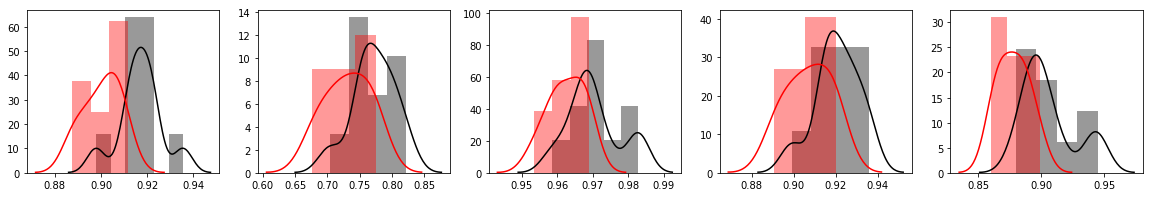

In [42]:
## Distribution by metric

import seaborn as sns

fig, axes = plt.subplots(ncols = 5)
fig.set_size_inches(20, 3)

sns.set_style({'axes.grid' : True})

sns.distplot(b_metrices[:, 0], color='k', ax = axes[0])
sns.distplot(e_metrices[:, 0], color='r', ax = axes[0])
sns.distplot(b_metrices[:, 1], color='k', ax = axes[1])
sns.distplot(e_metrices[:, 1], color='r', ax = axes[1])
sns.distplot(b_metrices[:, 2], color='k', ax = axes[2])
sns.distplot(e_metrices[:, 2], color='r', ax = axes[2])
sns.distplot(b_metrices[:, 3], color='k', ax = axes[3])
sns.distplot(e_metrices[:, 3], color='r', ax = axes[3])
sns.distplot(b_metrices[:, 4], color='k', ax = axes[4])
sns.distplot(e_metrices[:, 4], color='r', ax = axes[4])

fig.show()